In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Read Train data

In [2]:
file_path = "C:/Users/samar/OneDrive/Desktop/mathapp/APST/dataChallenge"
train_home_team_statistics_df = pd.read_csv(file_path + "/Train_Data/train_home_team_statistics_df.csv", index_col=0)
train_away_team_statistics_df = pd.read_csv(file_path + "/Train_Data/train_away_team_statistics_df.csv", index_col=0)

train_scores = pd.read_csv(file_path + "/Y_train.csv", index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [3]:
train_home_team_statistics_df.head()

LEAGUE                TEAM_NAME  TEAM_SHOTS_TOTAL_season_sum  \
ID                                                                         
0          Ligue 1                 Toulouse                          3.0   
1          Ligue 2                    Brest                          6.0   
2          Serie A                Sampdoria                          4.0   
3       League One            Coventry City                          7.0   
4   Premier League  Wolverhampton Wanderers                          3.0   

    TEAM_SHOTS_INSIDEBOX_season_sum  TEAM_SHOTS_OFF_TARGET_season_sum  \
ID                                                                      
0                               2.0                               5.0   
1                               8.0                               3.0   
2                               2.0                               5.0   
3                               5.0                               5.0   
4                               3.0                               2.0   

    TEAM_SHOTS_ON_TARGET_season_sum  TEAM_SHOTS_OUTSIDEBOX_season_sum  \
ID                                                                      
0                               2.0                               1.0   
1                               6.0                               5.0   
2                               2.0                               8.0   
3                               6.0                               6.0   
4                               3.0                               4.0   

    TEAM_PASSES_season_sum  TEAM_SUCCESSFUL_PASSES_season_sum  \
ID                                                              
0                      2.0                                2.0   
1                      8.0                                7.0   
2                      1.0                                1.0   
3                      9.0                                9.0   
4                      4.0                                3.0   

    TEAM_SAVES_season_sum  ...  TEAM_YELLOWCARDS_5_last_match_std  \
ID                         ...                                      
0                     5.0  ...                                3.0   
1                    10.0  ...                                4.0   
2                     2.0  ...                                4.0   
3                     2.0  ...                                4.0   
4                     4.0  ...                                1.0   

    TEAM_REDCARDS_5_last_match_std  TEAM_OFFSIDES_5_last_match_std  \
ID                                                                   
0                              0.0                             6.0   
1                              0.0                             4.0   
2                              5.0                             6.0   
3                              0.0                             1.0   
4                              0.0                             2.0   

    TEAM_ATTACKS_5_last_match_std  TEAM_PENALTIES_5_last_match_std  \
ID                                                                   
0                             0.0                             10.0   
1                             3.0                             10.0   
2                             3.0                              6.0   
3                             8.0                              8.0   
4                             5.0                              8.0   

    TEAM_SUBSTITUTIONS_5_last_match_std  TEAM_BALL_SAFE_5_last_match_std  \
ID                                                                         
0                                   8.0                              7.0   
1                                   0.0                              1.0   
2                                   7.0                              2.0   
3                                   5.0                              5.0   
4                                   7.0                              2.0   



In [4]:
train_scores.head()

HOME_WINS  DRAW  AWAY_WINS
ID                            
0           0     0          1
1           0     1          0
2           0     0          1
3           1     0          0
4           0     1          0

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight

train_data.fillna(0, inplace=True)

# Targets
train_scores['TARGET'] = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
target_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores['TARGET'] = train_scores['TARGET'].map(target_mapping)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_scores['TARGET'], test_size=0.2, random_state=42
)

# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [6]:
class_weights_dict

{0: 0.7677665964583821, 1: 1.2785138997142116, 2: 1.0924630924630925}

## Gradient Boosting Model

In [ ]:

# Model and Hyperparameter Tuning
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    gb_model, param_grid=params, scoring='accuracy', cv=3, verbose=1, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Evaluate Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
importances = best_model.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Features:\n", feature_importance)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.4961397805770012
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.84      0.62      1083
           1       0.43      0.01      0.02       620
           2       0.50      0.40      0.44       758

    accuracy                           0.50      2461
   macro avg       0.47      0.42      0.36      2461
weighted avg       0.48      0.50      0.42      2461

Top 10 Features:
                                       Feature  Importance
173  AWAY_TEAM_BALL_POSSESSION_season_average    0.032564
23       HOME_TEAM_SHOTS_TOTAL_season_average    0.024773
3        HOME_TEAM_SHOTS_ON_TARGET_season_sum    0.020450
22             HOME_TEAM_GAME_LOST_season_sum    0.020117
160             AWAY_TEAM_GAME_WON_season_sum    0.019709
33   HOME_TEAM_BALL_POSSESSION_season_aver

In [ ]:
#using class weight
params1 = {
    'n_estimators': 200,
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.8,
    'random_state': 42
}
gb_model = GradientBoostingClassifier(**params1)

sample_weights = [class_weights_dict[label] for label in y_train]
gb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with class weights:", accuracy)

Accuracy with class weights: 0.44900446972775293


In [ ]:
# Using class weights can decrease accuracy if the adjustment overemphasizes minority classes, leading the model to misclassify majority class instances more often. 
# This happens because class weights effectively alter the loss function, penalizing errors in the minority class more heavily.

# This is useful for imbalanced datasets where minority classes are underrepresented,
#  but if the dataset is not highly imbalanced, the re-weighting can disrupt the model's balance, reducing its ability to generalize effectively.

### submission

In [24]:

test_home = pd.read_csv(file_path + "/Test_Data/test_home_team_statistics_df.csv", index_col=0)
test_away = pd.read_csv(file_path + "/Test_Data/test_away_team_statistics_df.csv", index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1).fillna(0)

predictions = best_model.predict(test_data)


In [25]:
predictions

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

In [26]:

predictions_sub = np.zeros((predictions.size, 3))
for i in range(predictions.size):
    predictions_sub[i][predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB

ID  HOME_WINS  DRAW  AWAY_WINS
0      12303          1     0          0
1      12304          0     0          1
2      12305          1     0          0
3      12306          1     0          0
4      12307          0     0          1
...      ...        ...   ...        ...
25363  37666          1     0          0
25364  37667          1     0          0
25365  37668          1     0          0
25366  37669          1     0          0
25367  37670          1     0          0

[25368 rows x 4 columns]

In [27]:
submissionGB.to_csv(file_path + "/team_submission_gb.csv", index=False)

In [ ]:
# resulted in 

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest with hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on validation data
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)


Random Forest Accuracy: 0.4746038195855343


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize Random Forest and Grid Search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Evaluate
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': train_data.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features:\n", feature_importances.head(10))

Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 300}
Training Accuracy: 1.0
Testing Accuracy: 0.48720032507110933

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62      1083
           1       0.25      0.03      0.06       620
           2       0.48      0.41      0.44       758

    accuracy                           0.49      2461
   macro avg       0.41      0.41      0.37      2461
weighted avg       0.43      0.49      0.42      2461


Top Features:
                                       Feature  Importance
22             HOME_TEAM_GAME_LOST_season_sum    0.005336
20              HOME_TEAM_GAME_WON_season_sum    0.005177
47         HOME_TEAM_GAME_LOST_season_average    0.005169
45          HOME_TEAM_GAME_WON_season_average    0.005135
160             AWAY_TEAM_GAME_WON_season_sum    0.005051
162            AWAY_TEAM_GAME_LOST_season_sum    0.

### submission

In [30]:
predictions = best_rf.predict(test_data)
predictions_sub = np.zeros((predictions.size, 3))
for i in range(predictions.size):
    predictions_sub[i][predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB.to_csv(file_path + "/team_submission_rf.csv", index=False)


## Neural Network

In [31]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_test)

# Define the model
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),  # Regularization
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(y_train.unique()), activation='softmax')  # Multiclass classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_test), verbose=1)

# Predict and evaluate
y_pred_nn = nn_model.predict(X_val_scaled)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)
nn_accuracy = accuracy_score(y_test, y_pred_nn_classes)
print("Neural Network Accuracy:", nn_accuracy)

Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4253 - loss: 1.1670 - val_accuracy: 0.4596 - val_loss: 1.0446
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4832 - loss: 1.0303 - val_accuracy: 0.4738 - val_loss: 1.0343
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5056 - loss: 1.0067 - val_accuracy: 0.4742 - val_loss: 1.0384
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5043 - loss: 0.9991 - val_accuracy: 0.4791 - val_loss: 1.0334
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5084 - loss: 0.9856 - val_accuracy: 0.4831 - val_loss: 1.0427
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5241 - loss: 0.9710 - val_accuracy: 0.4770 - val_loss: 1.0390
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5425 - loss: 0.9606 - val_accuracy: 0.4734 - val_loss: 1.0430
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5382 - loss: 0.9583 - val_accuracy: 0.

In [32]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_test)

# Define the model
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(y_train.unique()), activation='softmax')  # Multiclass classification
])

# Compile the model
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predict and evaluate
y_pred_nn = nn_model.predict(X_val_scaled)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)
nn_accuracy = accuracy_score(y_test, y_pred_nn_classes)
print("Neural Network Accuracy:", nn_accuracy)


Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4043 - loss: 1.2462 - val_accuracy: 0.4632 - val_loss: 1.0452 - learning_rate: 0.0010
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4546 - loss: 1.0779 - val_accuracy: 0.4746 - val_loss: 1.0414 - learning_rate: 0.0010
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4768 - loss: 1.0387 - val_accuracy: 0.4730 - val_loss: 1.0365 - learning_rate: 0.0010
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4817 - loss: 1.0351 - val_accuracy: 0.4783 - val_loss: 1.0323 - learning_rate: 0.0010
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4970 - loss: 1.0130 - val_accuracy: 0.4823 - val_loss: 1.0289 - learning_rate: 0.0010
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4913 - loss: 1.0130 - val_accuracy: 0.4815 - val_loss: 1.0336 - learning_rate: 0.0010
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5031 - loss: 1.

### submission

In [ ]:
predictions = nn_model.predict(test_data)
predictions_sub = np.zeros((predictions.size, 3))
for i in range(predictions.size):
    predictions_sub[i][predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB.to_csv(file_path + "/team_submission_nn.csv", index=False)

## xgb model

In [33]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.48760666395774077


[0]	train-mlogloss:1.09200	eval-mlogloss:1.09631
[100]	train-mlogloss:0.70003	eval-mlogloss:1.02493
[200]	train-mlogloss:0.50605	eval-mlogloss:1.02599
[246]	train-mlogloss:0.44026	eval-mlogloss:1.02861
Validation Accuracy: 0.4888256806176351


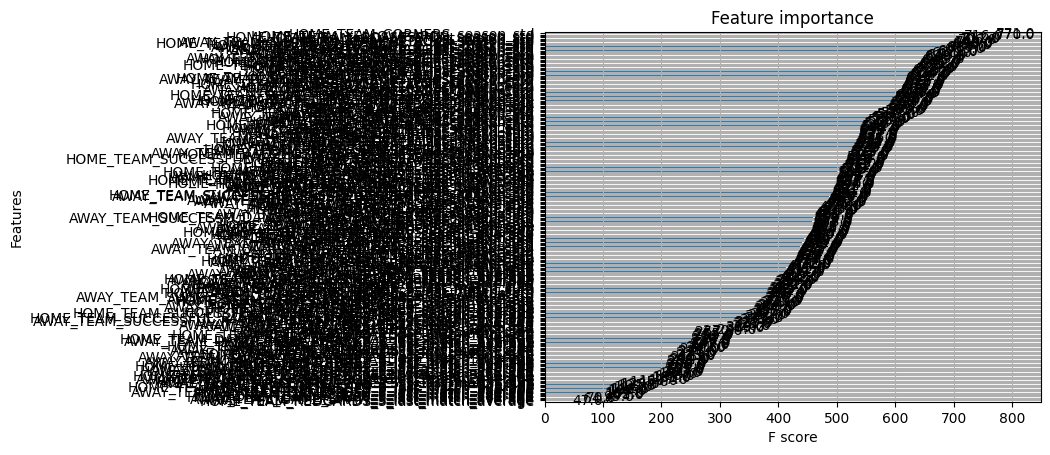

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    train_data, train_scores['TARGET'], test_size=0.2, random_state=42, stratify=train_scores['TARGET']
    
)

# XGBoost parameters
params = {
    'objective': 'multi:softmax',  # for classification
    'num_class': 3,  # number of classes
    'max_depth': 8,
    'learning_rate': 0.02,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,  # L1 regularization
    'lambda': 1.0,  # L2 regularization
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model1 = xgb.train(
    params, dtrain, num_boost_round=10000, evals=evals, 
    early_stopping_rounds=100, verbose_eval=100
)

# Predictions
y_pred = xgb_model1.predict(xgb.DMatrix(X_val))
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

# Feature importance
xgb.plot_importance(xgb_model1)
plt.show()


Automated Tuning: Use Optuna:

In [36]:
import optuna

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 0.01, 10),
        'lambda': trial.suggest_loguniform('lambda', 0.01, 10),
        'eval_metric': 'mlogloss',
        'random_state': 42
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    evals = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrain, evals=evals, early_stopping_rounds=50, verbose_eval=False)
    y_pred = model.predict(dval)
    return accuracy_score(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best Parameters:", study.best_params)


[I 2024-11-26 20:40:40,124] A new study created in memory with name: no-name-dc65ec1f-4284-4c4e-9d9b-a1274e8a7582
[I 2024-11-26 20:40:40,486] Trial 0 finished with value: 0.49085737505079235 and parameters: {'max_depth': 6, 'learning_rate': 0.07021260560233708, 'subsample': 0.6668681899547023, 'colsample_bytree': 0.7776178214928091, 'alpha': 9.908878350396783, 'lambda': 1.345703260026848}. Best is trial 0 with value: 0.49085737505079235.
[I 2024-11-26 20:40:41,090] Trial 1 finished with value: 0.4681023973994311 and parameters: {'max_depth': 10, 'learning_rate': 0.03866505688641077, 'subsample': 0.6869390323403369, 'colsample_bytree': 0.6293897398212013, 'alpha': 0.011792229173864152, 'lambda': 9.073367366398525}. Best is trial 0 with value: 0.49085737505079235.
[I 2024-11-26 20:40:41,527] Trial 2 finished with value: 0.4693214140593255 and parameters: {'max_depth': 8, 'learning_rate': 0.10804512074982099, 'subsample': 0.7352528112631441, 'colsample_bytree': 0.7476583434280456, 'alpha'

Best Parameters: {'max_depth': 7, 'learning_rate': 0.1188516058385093, 'subsample': 0.6857797696838556, 'colsample_bytree': 0.8545749779308204, 'alpha': 6.536966585403368, 'lambda': 0.5410829919864539}


In [37]:
#using best params
# XGBoost parameters
best_params = {
    'objective': 'multi:softmax',  # for classification
    'num_class': 3,  # number of classes
    'max_depth': 7,
    'learning_rate': 0.11,
    'n_estimators': 1000,
    'subsample': 0.685,
    'colsample_bytree': 0.854,
    'alpha': 6.5369,  # L1 regularization
    'lambda': 0.541,  # L2 regularization
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    best_params, dtrain, num_boost_round=10000, evals=evals, 
    early_stopping_rounds=100, verbose_eval=100
)

# Predictions
y_pred = model.predict(xgb.DMatrix(X_val))
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

[0]	train-mlogloss:1.08069	eval-mlogloss:1.08768
[100]	train-mlogloss:0.56049	eval-mlogloss:1.03678
[127]	train-mlogloss:0.49247	eval-mlogloss:1.04204
Validation Accuracy: 0.4766355140186916


### submission

In [44]:
X_bench = xgb.DMatrix(test_data)

predictions = xgb_model1.predict(X_bench, iteration_range=(0, xgb_model1.best_iteration))
predictions_sub = np.zeros((predictions.size, 3), dtype=int)
for i in range(predictions.size):
    predictions_sub[i][int(predictions[i])] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB.to_csv(file_path + "/team_submission_xgb.csv", index=False)

## Catboost model

In [45]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    random_seed=42,
    verbose=100
)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)
y_pred_cat = catboost_model.predict(X_test)

print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cat))

0:	learn: 1.0946987	test: 1.0948340	best: 1.0948340 (0)	total: 24ms	remaining: 12s
100:	learn: 0.9884844	test: 0.9964817	best: 0.9964817 (100)	total: 3.09s	remaining: 12.2s
200:	learn: 0.9557386	test: 0.9704028	best: 0.9704028 (200)	total: 5.2s	remaining: 7.74s
300:	learn: 0.9260041	test: 0.9478518	best: 0.9478518 (300)	total: 7.28s	remaining: 4.81s
400:	learn: 0.8919752	test: 0.9217427	best: 0.9217427 (400)	total: 9.55s	remaining: 2.36s
499:	learn: 0.8588030	test: 0.8950413	best: 0.8950413 (499)	total: 11.6s	remaining: 0us

bestTest = 0.8950412905
bestIteration = 499

CatBoost Accuracy: 0.6066639577407558


In [46]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

# Initialize CatBoost with tuned hyperparameters
cat_model = CatBoostClassifier(
    iterations=1000,
    depth=10,
    learning_rate=0.03,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    class_weights=class_weights_dict,
    early_stopping_rounds=50
)

# Stratified K-Fold for robust evaluation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    cat_model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        verbose=100,
        plot=False
    )
    y_pred_val = cat_model.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred_val)
    accuracies.append(accuracy)

# Average accuracy across folds
print(f"Cross-validated Accuracy: {sum(accuracies) / len(accuracies)}")

# Final fit on full training data
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, plot=True)

# Predict and evaluate
y_pred = cat_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy:", final_accuracy)


0:	learn: 0.5194326	test: 0.3945415	best: 0.3945415 (0)	total: 87.9ms	remaining: 1m 27s
100:	learn: 0.8258277	test: 0.4601706	best: 0.4640675 (93)	total: 10.9s	remaining: 1m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4640674691
bestIteration = 93

Shrink model to first 94 iterations.
0:	learn: 0.5027246	test: 0.3897703	best: 0.3897703 (0)	total: 132ms	remaining: 2m 12s
100:	learn: 0.8189421	test: 0.4220267	best: 0.4360945 (60)	total: 10.4s	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4360944921
bestIteration = 60

Shrink model to first 61 iterations.
0:	learn: 0.5311477	test: 0.3925112	best: 0.3925112 (0)	total: 98.2ms	remaining: 1m 38s
100:	learn: 0.8160904	test: 0.4363847	best: 0.4421067 (88)	total: 10.4s	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4421067311
bestIteration = 88

Shrink model to first 89 iterations.
0:	learn: 0.5144584	test: 0.4128501	best: 0.4128501 (0)	tot

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5034648	test: 0.4798220	best: 0.4798220 (0)	total: 196ms	remaining: 3m 15s
100:	learn: 0.7920151	test: 0.7202467	best: 0.7207970 (99)	total: 14.1s	remaining: 2m 5s
200:	learn: 0.8897539	test: 0.8016220	best: 0.8049211 (196)	total: 25.6s	remaining: 1m 41s
300:	learn: 0.9492288	test: 0.8451191	best: 0.8459039 (295)	total: 39.2s	remaining: 1m 31s
400:	learn: 0.9790709	test: 0.8702406	best: 0.8710750 (398)	total: 50.1s	remaining: 1m 14s
500:	learn: 0.9928423	test: 0.8802263	best: 0.8811655 (498)	total: 1m 1s	remaining: 1m 1s
600:	learn: 0.9980484	test: 0.8857583	best: 0.8859666 (589)	total: 1m 12s	remaining: 48s
700:	learn: 0.9996097	test: 0.8889927	best: 0.8898836 (697)	total: 1m 21s	remaining: 34.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8905663542
bestIteration = 746

Shrink model to first 747 iterations.
Final Accuracy: 0.8988216172287687


In [ ]:
# adding the class weight did not help in improving the model

### submission

In [ ]:
predictions = catboost_model.predict(test_data)
predictions_sub = np.zeros((predictions.size, 3))
for i in range(predictions.size):
    predictions_sub[i][predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB.to_csv(file_path + "/team_submission_catboost.csv", index=False) #0.4877798

In [ ]:
predictions = cat_model.predict(test_data)
predictions_sub = np.zeros((predictions.size, 3))
for i in range(predictions.size):
    predictions_sub[i][predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB.to_csv(file_path + "/team_submission_cat_model.csv", index=False) #0.4719

## LightGBM

In [48]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 9842, number of used features: 280
[LightGBM] [Info] Start training from score -0.831772
[LightGBM] [Info] Start training from score -1.350958
[LightGBM] [Info] Start training from score -1.185051
LightGBM Accuracy: 0.8760666395774076


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Define LightGBM model
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    class_weight='balanced'
)

# Hyperparameter tuning with GridSearchCV
params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 40, 50],
    'max_depth': [5, 7, 10],
    'n_estimators': [200, 300, 400]
}

grid_search = GridSearchCV(lgb_model, params, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_lgb_model = grid_search.best_estimator_

# Train and evaluate
y_pred_lgb = best_lgb_model.predict(X_test)
print("Improved LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))

print("Best Parameters:", best_lgb_model.get_params)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 6561, number of used features: 280
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

### submission

In [ ]:
predictions = best_lgb_model.predict(test_data)
predictions_sub = np.zeros((predictions.size, 3))
for i in range(predictions.size):
    predictions_sub[i][predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB.to_csv(file_path + "/team_submission_lgbm.csv", index=False) #0.46263

## Stacking Ensemble

In [51]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

base_models = [
    ('xgb', xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5)),
    ('cat', CatBoostClassifier(iterations=300, learning_rate=0.03, depth=6, verbose=0)),
    ('lgb', lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=7))
]
stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)

print("Stacking Accuracy:", accuracy_score(y_test, y_pred_stack))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 9842, number of used features: 280
[LightGBM] [Info] Start training from score -0.831772
[LightGBM] [Info] Start training from score -1.350958
[LightGBM] [Info] Start training from score -1.185051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 7873, number of used features: 280
[LightGBM] [Info] Start training from score -0.831754
[LightGBM] [Info] Start training from score -1.350980
[LightGBM] [Info] Start 

In [52]:
# Base models
base_models = [
    ('xgb', xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5)),
    ('cat', CatBoostClassifier(iterations=300, learning_rate=0.03, depth=6, verbose=0)),
    ('lgb', lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=7))
]

# Stacking model with logistic regression
stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Hyperparameter grid for GridSearchCV
param_grid = {
    'final_estimator__C': [0.1, 1, 10],
    'final_estimator__solver': ['lbfgs', 'liblinear'],
}

grid_search = GridSearchCV(stack_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_stack_model = grid_search.best_estimator_

# Evaluate
y_pred_stack = best_stack_model.predict(X_test)
print("Improved Stacking Accuracy:", accuracy_score(y_test, y_pred_stack))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 6561, number of used features: 280
[LightGBM] [Info] Start training from score -0.831721
[LightGBM] [Info] Start training from score -1.351103
[LightGBM] [Info] Start training from score -1.185000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 280
[LightGBM] [Info] Start training from score -0.831481
[LightGBM] [Info] Start training from score -1.351098
[LightGBM] [Info] Start training from score -1.185347
[LightGBM] [Info] Auto-choosing co

### submission

In [ ]:
predictions = best_stack_model.predict(test_data)
predictions_sub = np.zeros((predictions.size, 3))
for i in range(predictions.size):
    predictions_sub[i][predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = test_data.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().reset_index()
submissionGB.to_csv(file_path + "/team_submission_stacking_ensemble.csv", index=False) #0.48675

## Benchmark

We try to model if AWAY wins

In [13]:
train_new_y = train_scores['AWAY_WINS']

### train, valid test split

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


### xgb model

In [15]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:0.68338	eval-mlogloss:0.68785
[1]	train-mlogloss:0.67389	eval-mlogloss:0.68266
[2]	train-mlogloss:0.66467	eval-mlogloss:0.67757
[3]	train-mlogloss:0.65574	eval-mlogloss:0.67304
[4]	train-mlogloss:0.64724	eval-mlogloss:0.66849
[5]	train-mlogloss:0.63894	eval-mlogloss:0.66438
[6]	train-mlogloss:0.63052	eval-mlogloss:0.66062
[7]	train-mlogloss:0.62230	eval-mlogloss:0.65697
[8]	train-mlogloss:0.61454	eval-mlogloss:0.65359
[9]	train-mlogloss:0.60701	eval-mlogloss:0.65015
[10]	train-mlogloss:0.59949	eval-mlogloss:0.64682
[11]	train-mlogloss:0.59224	eval-mlogloss:0.64347
[12]	train-mlogloss:0.58520	eval-mlogloss:0.64026
[13]	train-mlogloss:0.57876	eval-mlogloss:0.63741
[14]	train-mlogloss:0.57188	eval-mlogloss:0.63467
[15]	train-mlogloss:0.56536	eval-mlogloss:0.63191
[16]	train-mlogloss:0.55888	eval-mlogloss:0.62946
[17]	train-mlogloss:0.55254	eval-mlogloss:0.62681
[18]	train-mlogloss:0.54669	eval-mlogloss:0.62444
[19]	train-mlogloss:0.54078	eval-mlogloss:0.62231
[20]	train

### Some analysis

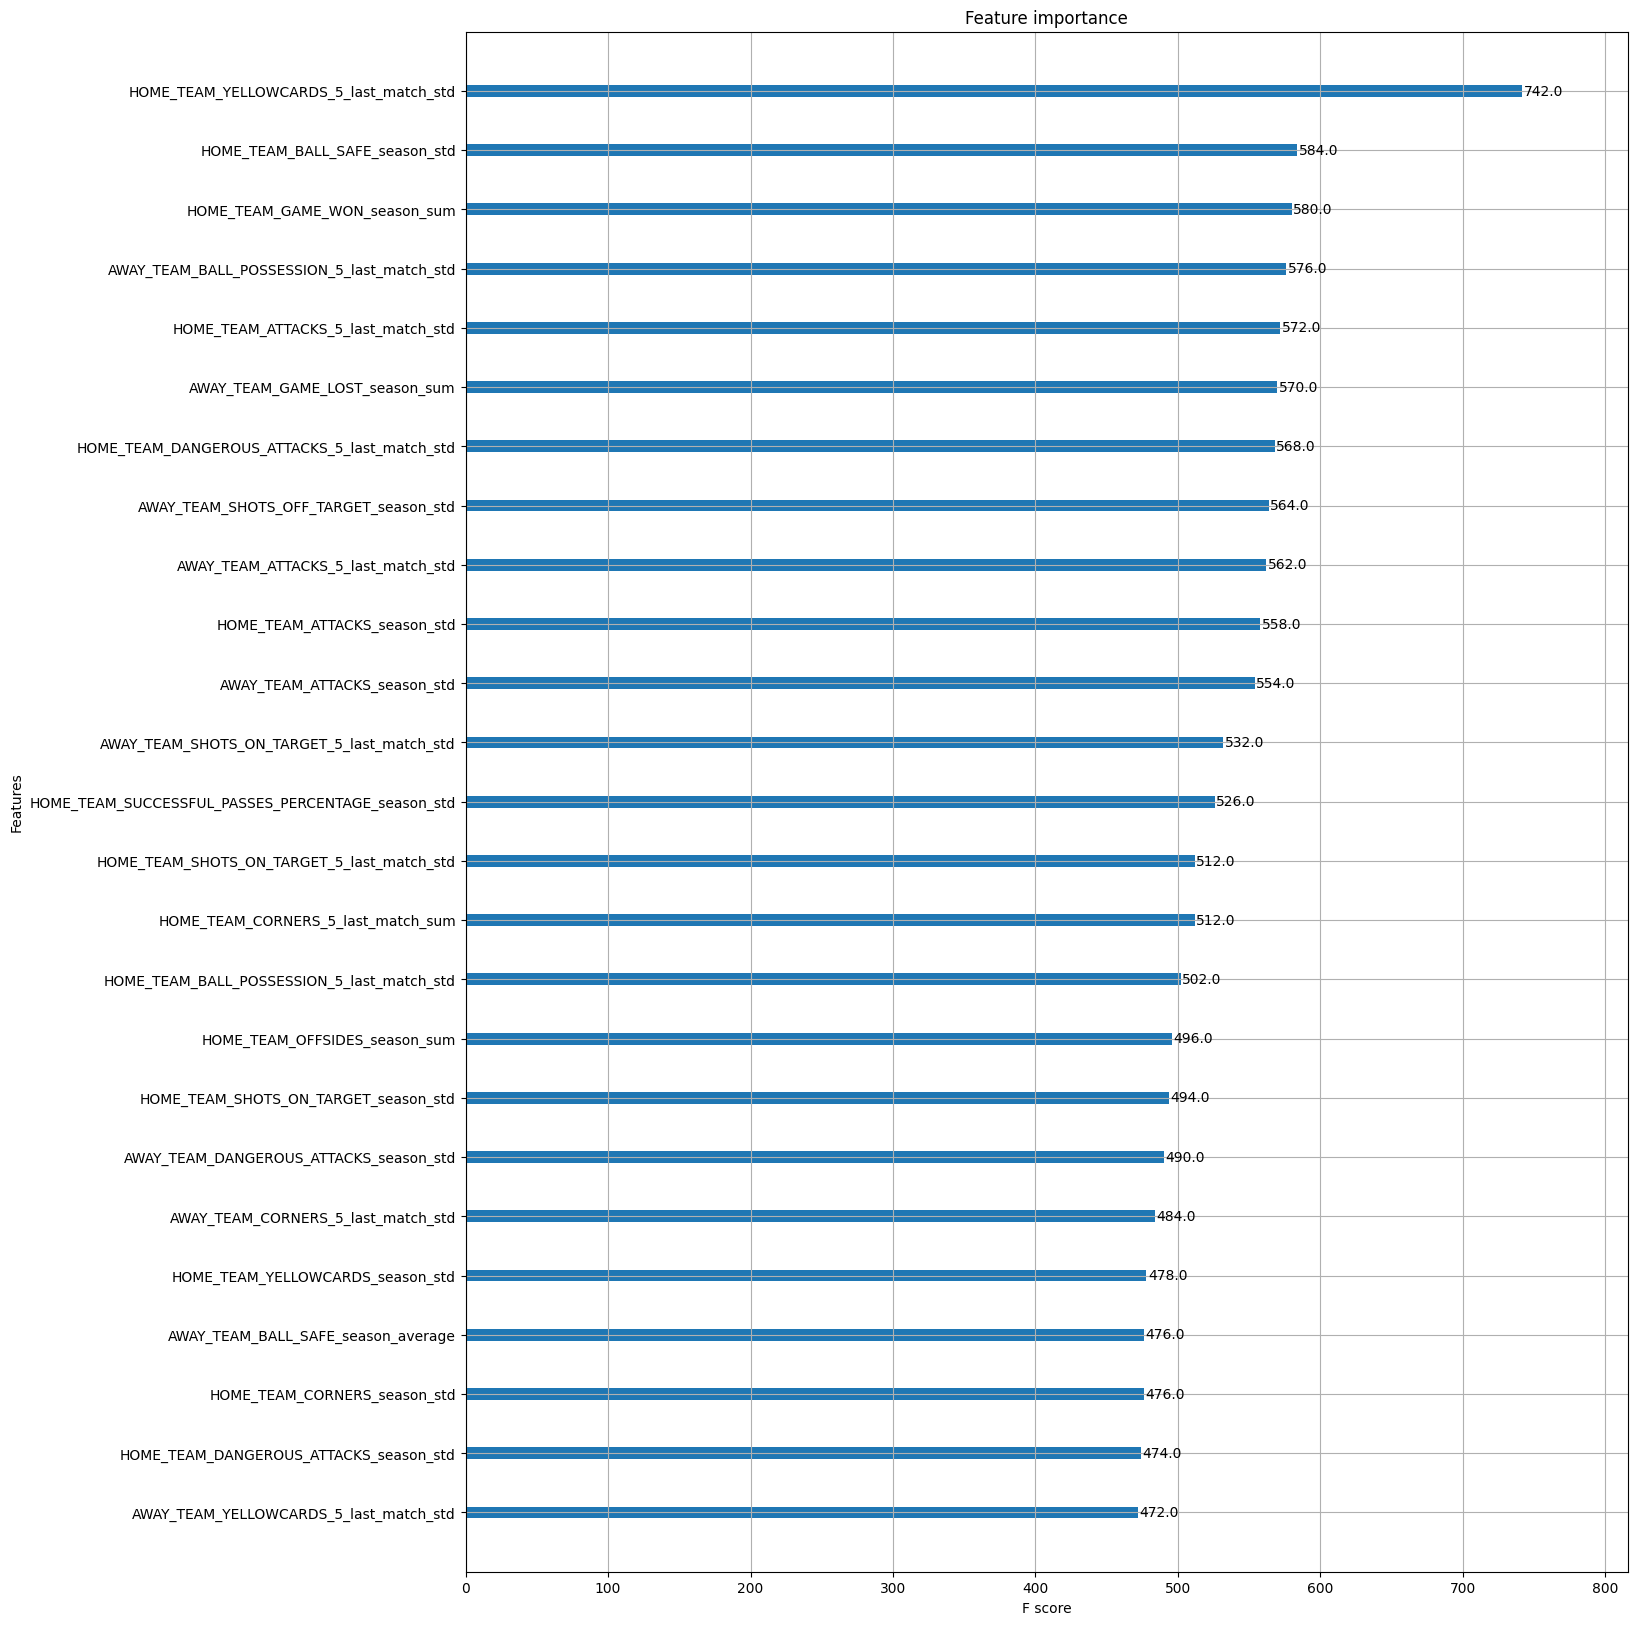

In [16]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)


### Accuracy on test set

A simple benchmark is always predicting home wins

In [ ]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


0.4401

Using our model

In [18]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)


0.4742

In [23]:
predictions.head()

HOME_WINS  DRAW  AWAY_WINS
ID                               
12303          1     0          0
12304          0     0          1
12305          1     0          0
12306          1     0          0
12307          1     0          0

## Submission

In [20]:

test_home = pd.read_csv(file_path + "/Test_Data/test_home_team_statistics_df.csv", index_col=0)
test_away = pd.read_csv(file_path + "/Test_Data/test_away_team_statistics_df.csv", index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)


In [35]:
test_data.head()

HOME_TEAM_SHOTS_TOTAL_season_sum  HOME_TEAM_SHOTS_INSIDEBOX_season_sum  \
ID                                                                              
12303                               3.0                                   6.0   
12304                               3.0                                   2.0   
12305                               7.0                                  10.0   
12306                               5.0                                   7.0   
12307                               5.0                                   4.0   

       HOME_TEAM_SHOTS_OFF_TARGET_season_sum  \
ID                                             
12303                                    5.0   
12304                                    4.0   
12305                                    8.0   
12306                                    5.0   
12307                                    6.0   

       HOME_TEAM_SHOTS_ON_TARGET_season_sum  \
ID                                            
12303                                   1.0   
12304                                   2.0   
12305                                   8.0   
12306                                   9.0   
12307                                   3.0   

       HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum  HOME_TEAM_PASSES_season_sum  \
ID                                                                          
12303                                    3.0                          9.0   
12304                                    6.0                          1.0   
12305                                    1.0                          4.0   
12306                                    5.0                          7.0   
12307                                    5.0                          0.0   

       HOME_TEAM_SUCCESSFUL_PASSES_season_sum  HOME_TEAM_SAVES_season_sum  \
ID                                                                          
12303                                     8.0                        10.0   
12304                                     1.0                         2.0   
12305                                     5.0                         0.0   
12306                                     6.0                         3.0   
12307                                     0.0                         2.0   

       HOME_TEAM_CORNERS_season_sum  HOME_TEAM_FOULS_season_sum  ...  \
ID                                                               ...   
12303                           6.0                         7.0  ...   
12304                           4.0                        10.0  ...   
12305                          10.0                         4.0  ...   
12306                           5.0                         8.0  ...   
12307                           2.0                         9.0  ...   

       AWAY_TEAM_YELLOWCARDS_5_last_match_std  \
ID                                              
12303                                     6.0   
12304                                     0.0   
12305                                    10.0   
12306                                     1.0   
12307                                     3.0   

       AWAY_TEAM_REDCARDS_5_last_match_std  \
ID                                           
12303                                  0.0   
12304                                  0.0   
12305                                  0.0   
12306                                  5.0   
12307                                  0.0   

       AWAY_TEAM_OFFSIDES_5_last_match_std  \
ID                                           
12303                                  1.0   
12304                                  3.0   
12305                                  0.0   
12306                                  4.0   
12307                                  6.0   

       AWAY_TEAM_ATTACKS_5_last_match_std  \
ID                                          
12303                                 4.0   
12304                                 6.0   
12305            

In [29]:
X_bench = xgb.DMatrix(test_data)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions

array([[0.7129295 , 0.28707045],
       [0.49206376, 0.50793624],
       [0.86635745, 0.13364255],
       ...,
       [0.9010932 , 0.09890684],
       [0.8468541 , 0.1531459 ],
       [0.68968666, 0.31031334]], dtype=float32)

In [36]:
X_bench = xgb.DMatrix(test_data)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)


predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)
predictions

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()
submission
# submission.to_csv('./datas_final/benchmark_submission.csv', index=False)


ID  HOME_WINS  DRAW  AWAY_WINS
0      12303          1     0          0
1      12304          0     0          1
2      12305          1     0          0
3      12306          1     0          0
4      12307          1     0          0
...      ...        ...   ...        ...
25363  37666          1     0          0
25364  37667          1     0          0
25365  37668          1     0          0
25366  37669          1     0          0
25367  37670          1     0          0

[25368 rows x 4 columns]